In [41]:
import gpytorch
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline

In [42]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) # p(f)

### Prepare data

/users/eleves-a/2020/jean.dimier-de-la-brunetiere/miniconda3/envs/bayesian_ml/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/users/eleves-a/2020/jean.dimier-de-la-brunetiere/miniconda3/envs/bayesian_ml/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Text(0.5, 1.0, 'Test data')

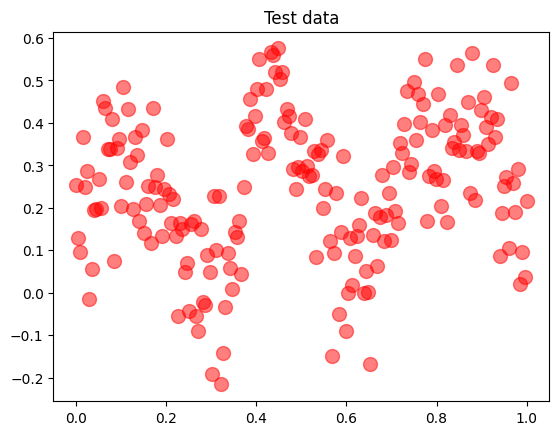

In [43]:
# x = torch.linspace(0., 1., 200)\
seed = 22
# true_nu = .5

x = np.linspace(0., 1., 200)
np.random.seed(seed)
torch.manual_seed(seed)
np.random.shuffle(x)
x = torch.from_numpy(x).float()

kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
gp = ExactGPModel(
    train_x=None,
    train_y=None,
    likelihood=gpytorch.likelihoods.GaussianLikelihood(), # p(y|f)
    kernel=kernel
)


true_noise = 0.1
overestimated_noise = 2 * true_noise

#This boolean changes the way LML behaves drastically
overestimate = True

true_lengthscale = 0.3
true_alpha = .05

gp.covar_module.base_kernel.lengthscale = true_lengthscale
gp.covar_module.base_kernel.alpha = true_alpha
gp.eval()
f_preds = gp(x) 
f = f_preds.rsample().detach()
y = f + true_noise * torch.randn(len(x))

plt.plot(x, y, "ro", ms=10, alpha=0.5)
plt.title("Test data")

In [44]:
split_n = 50
eval_x = x[split_n:]
x = x[:split_n]
eval_y = y[split_n:]
eval_f = f[split_n:]
y = y[:split_n]

In [45]:
order = np.argsort(eval_x)
eval_x = eval_x[order]
eval_f = eval_f[order]
eval_y = eval_y[order]

Text(0.5, 1.0, 'Train data')

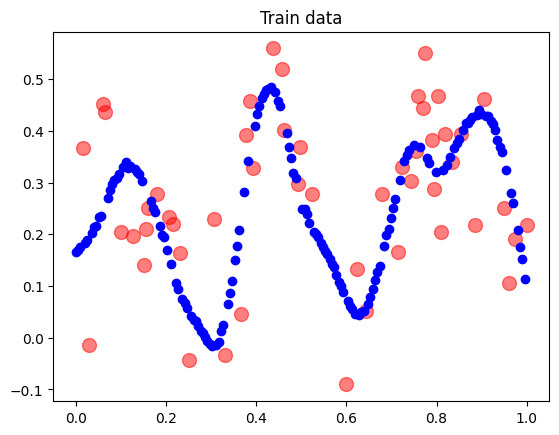

In [46]:
plt.plot(x, y, "ro", ms=10, alpha=0.5)
plt.plot(eval_x, eval_f, 'bo')
plt.title("Train data")

In [47]:
# np.savez("plots/data/gp_rq/data.npz",
#         x_train=x,
#         y_train=y,
#         x_test=eval_x,
#         y_test=eval_y,
#         f_test=eval_f)

In [48]:
x.shape

torch.Size([50])

### Error vs MLL vs CMLL

In [49]:
alpha_array = torch.linspace(0.0, 0.6, 300)

In [50]:
# true_noise = np.sqrt(0.03)
# true_noise = 0.03

true_noise = 0.1
# true_noise = 0.2

tensor(0.1104)


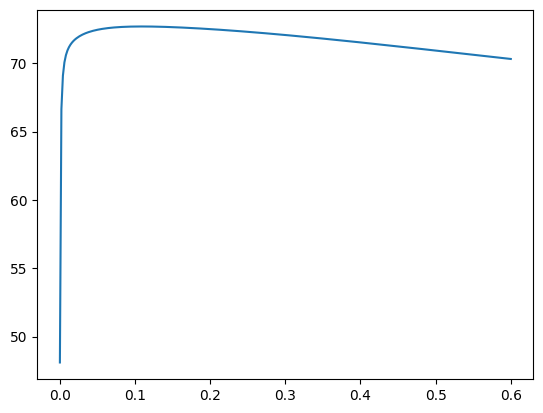

In [51]:
error_ll = []
overestimated_noise = 0.2

for kernel_ll in alpha_array:
    
    kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
    noise = torch.tensor([overestimated_noise**2]) if overestimate else torch.tensor([true_noise**2])

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise_covar.noise = noise
    gp = ExactGPModel(
        train_x=x,#[:40],
        train_y=y,#[:40],
        likelihood=likelihood,
        kernel=kernel
    )
    gp.covar_module.base_kernel.lengthscale = true_lengthscale
    gp.covar_module.base_kernel.alpha = kernel_ll
    gp.eval()
    likelihood.eval()
    f_preds = gp(eval_x)
    y_preds = likelihood(f_preds)

    error = y_preds.log_prob(eval_y)
    
    error_ll.append(error.item())

plt.plot(alpha_array, error_ll)

print(alpha_array[np.argmax(error_ll)])

In [52]:
def get_log_mll(gp, x, y):
    N = len(x)
    covar_matrix = gp.covar_module(x,x).evaluate()
    covar_matrix += gp.likelihood.noise * torch.eye(N)
    log_mll = - 0.5 * (y.T @ torch.inverse(covar_matrix)) @ y 
    log_mll += - 0.5 * torch.logdet(covar_matrix)
    log_mll += - 0.5 * N * np.log(2 * np.pi)

    return log_mll

tensor(0.)


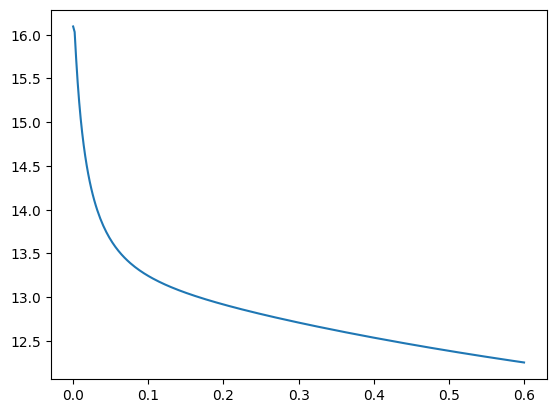

In [53]:
ml_ll = []

for kernel_ll in alpha_array:
    kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
    noise = torch.tensor([overestimated_noise**2]) if overestimate else torch.tensor([true_noise**2])

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise_covar.noise = noise
    gp = ExactGPModel(
        train_x=x,#[:40],
        train_y=y,#[:40],
        likelihood=likelihood,
        kernel=kernel
    )
    gp.covar_module.base_kernel.lengthscale = true_lengthscale
    gp.covar_module.base_kernel.alpha = kernel_ll
    gp.eval()
    likelihood.eval()
    
    ml_ll.append(get_log_mll(gp, x, y).item())

plt.plot(alpha_array, ml_ll)
print(alpha_array[np.argmax(ml_ll)])

tensor(0.1946)


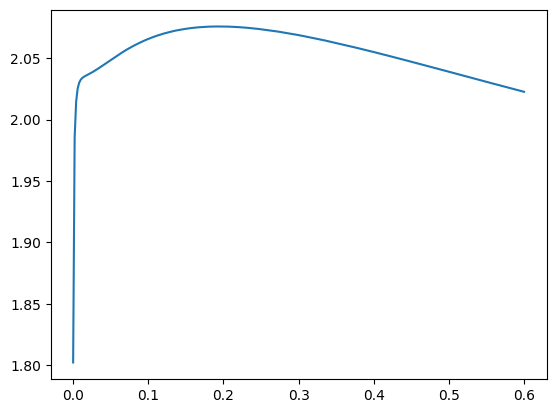

In [54]:
all_cml_ll = []
all_cml_error = []

m = 45
# m = 20
n_orders = 20

for _ in range(n_orders):
    cml_ll = []
    cml_error = []
    
    order = np.arange(len(x))
    np.random.shuffle(order)
    xm, ym = x[order[:m]], y[order[:m]]
    x_, y_ = x[order[m:]], y[order[m:]]

    for kernel_ll in alpha_array:

        kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
        noise = torch.tensor([overestimated_noise**2]) if overestimate else torch.tensor([true_noise**2])

        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood.noise_covar.noise = noise
        gp = ExactGPModel(
            train_x=xm,
            train_y=ym,
            likelihood=likelihood,
            kernel=kernel
        )
        gp.covar_module.base_kernel.lengthscale = true_lengthscale
        gp.covar_module.base_kernel.alpha = kernel_ll

        gp.eval()
        likelihood.eval()

        cml_ll.append((get_log_mll(gp, x, y) - get_log_mll(gp, xm, ym)).item())

        
    all_cml_ll.append(cml_ll)

all_cml_ll = np.array(all_cml_ll)
plt.plot(alpha_array, all_cml_ll.mean(0))
print(alpha_array[np.argmax(all_cml_ll.mean(0))])

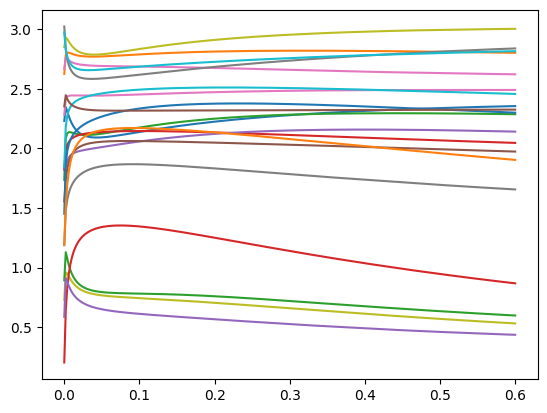

In [55]:
for i in range(n_orders):
    plt.plot(alpha_array, all_cml_ll[i])
# plt.plot(lengthscale_array, all_cml_ll[1])
# plt.plot(lengthscale_array, all_cml_ll[2])
# plt.plot(lengthscale_array, all_cml_ll[4])
# plt.plot(lengthscale_array, all_cml_ll[5])

In [56]:
def rescale(lst):
    lst = np.array(lst)
    return (lst - np.min(lst)) / (np.max(lst - np.min(lst)))

Text(0.5, 0, 'RQ kernel, $\\alpha$')

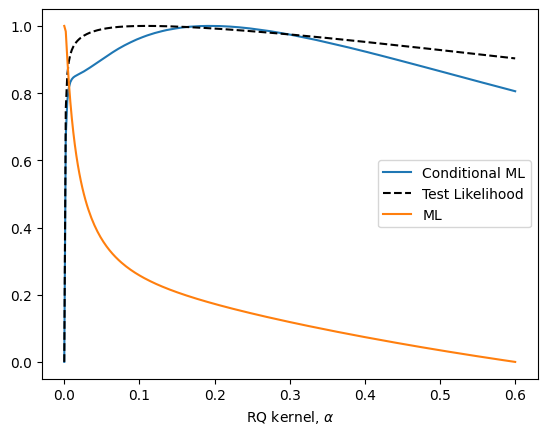

In [57]:
plt.plot(alpha_array, rescale(all_cml_ll.mean(0)), label="Conditional ML")
plt.plot(alpha_array, rescale(error_ll), "--k", label="Test Likelihood")
plt.plot(alpha_array, rescale(ml_ll), label="ML")
plt.legend()
plt.xlabel(r"RQ kernel, $\alpha$")

In [58]:
# np.savez("plots/data/gp_rq/alpha_optimization_small_noise.npz",
# # np.savez("plots/data/gp_rq/alpha_optimization_big_noise.npz",
#         alpha=alpha_array,
#         cmll=all_cml_ll.mean(0),
#         mll=ml_ll,
#         test_likelihood=error_ll)

In [59]:
i = np.argmax(all_cml_ll.mean(0))
alpha_cmll = alpha_array[i]
print("alpha: {} \t cmll: {} \t mll: {}".format(alpha_cmll.item(), all_cml_ll.mean(0)[i], ml_ll[i]))
# all_cml_ll.mean(0)

alpha: 0.1946488469839096 	 cmll: 2.0758903503417967 	 mll: 12.929710388183594


In [60]:
i = np.argmax(ml_ll)
alpha_cmll = alpha_array[i]
print("alpha: {} \t cmll: {} \t mll: {}".format(alpha_cmll.item(), all_cml_ll.mean(0)[i], ml_ll[i]))
# all_cml_ll.mean(0)

alpha: 0.0 	 cmll: 1.802202033996582 	 mll: 16.094226837158203


## How does MLL grow with observed data

In [61]:
import tqdm

In [62]:
true_noise = 0.2

In [63]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
noise = torch.tensor([overestimated_noise**2]) if overestimate else torch.tensor([true_noise**2])

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise = noise
gp = ExactGPModel(
    train_x=x,
    train_y=y,
    likelihood=likelihood,
    kernel=kernel
)
gp.covar_module.base_kernel.lengthscale = true_lengthscale
gp.covar_module.base_kernel.alpha = 0.01

In [64]:
x.shape

torch.Size([50])

In [65]:
x_combined = torch.cat([x, eval_x])
y_combined = torch.cat([y, eval_y])

In [66]:
alpha_lst = [0.001, 0.01, 0.1, 0.3]
mlls_data = {alpha: np.zeros((len(x_combined),)) for alpha in alpha_lst}
n_orders = 100

for _ in tqdm.tqdm(range(n_orders)):
    cml_ll = []
    cml_error = []
    
    order = np.arange(len(x_combined))
    np.random.shuffle(order)
    x_, y_ = x_combined[order], y_combined[order]
#     print(x_.shape)
    for alpha in alpha_lst:
        gp.covar_module.base_kernel.alpha = alpha
        mlls = np.array([get_log_mll(gp, x_[:i], y_[:i]).item() for i in range(len(x_combined))])
        mlls_data[alpha] += mlls / n_orders


  1%|          | 1/100 [00:00<01:04,  1.54it/s]

100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Text(0.5, 1.0, 'Rational quadratic kernel')

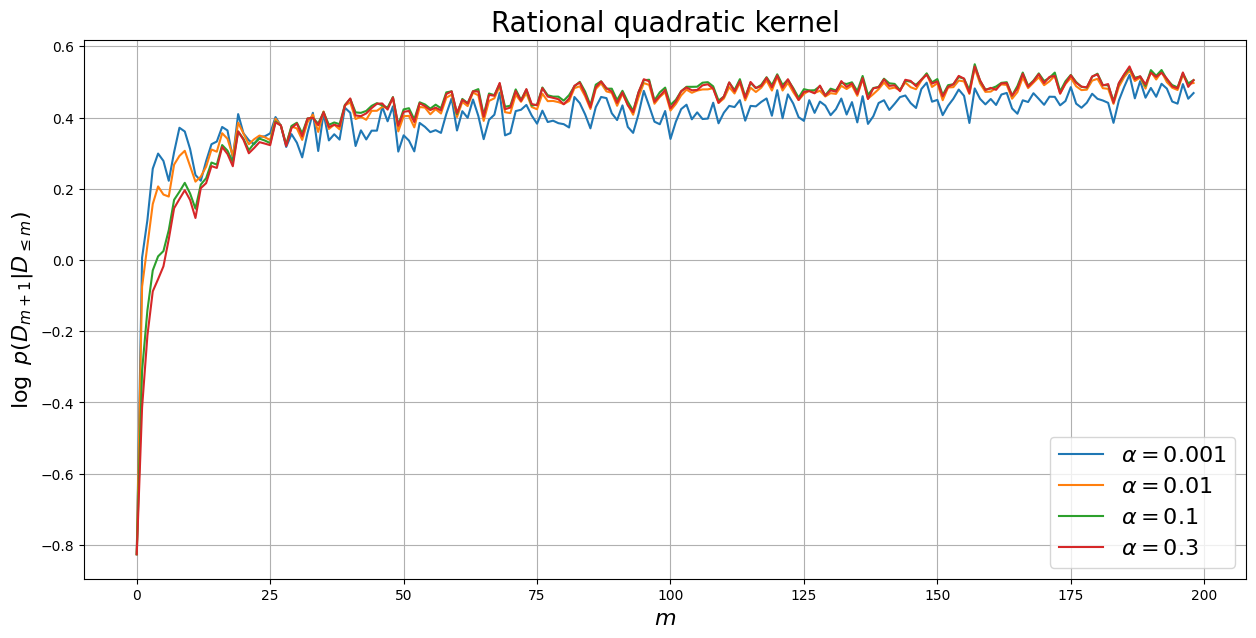

In [67]:
plt.figure(figsize=(15, 7))
plt.grid()

for alpha in alpha_lst:
    plt.plot(mlls_data[alpha][1:] - mlls_data[alpha][:-1], label=r"$\alpha={}$".format(alpha))

# mlls_data[-1]
plt.legend(fontsize=16)
plt.xlabel(r"$m$", fontsize=16)
plt.ylabel(r"$\log ~p(D_{m+1} \vert D_{ \leq m})$", fontsize=16)
plt.title("Rational quadratic kernel", fontsize=20)

In [68]:
mlls_data.keys()

dict_keys([0.001, 0.01, 0.1, 0.3])

In [69]:
# np.savez("plots/data/gp_rq/learning_curve.npz",
#         mlls_0001=mlls_data[0.001],
#         mlls_001=mlls_data[0.01],
#         mlls_01=mlls_data[0.1],
#         mlls_03=mlls_data[0.3],
#         )

Text(0.5, 1.0, 'Rational quadratic kernel')

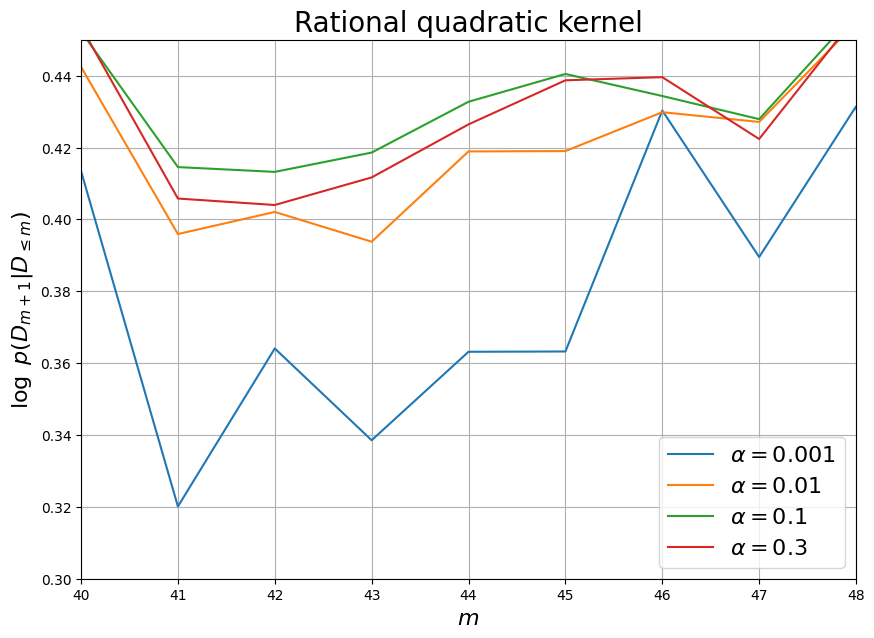

In [70]:
plt.figure(figsize=(10, 7))
plt.grid()

for alpha in alpha_lst:
    plt.plot((mlls_data[alpha][1:] - mlls_data[alpha][:-1]), label=r"$\alpha={}$".format(alpha))

# mlls_data[-1]
plt.xlim(40, 48)
plt.ylim(0.3, 0.45)
plt.legend(fontsize=16)
plt.xlabel(r"$m$", fontsize=16)
plt.ylabel(r"$\log ~p(D_{m+1} \vert D_{ \leq m})$", fontsize=16)
plt.title("Rational quadratic kernel", fontsize=20)

In [71]:
# plt.plot(mlls_data[1:] - mlls_data[:-1])

# mlls_data[-1]

In [72]:
get_log_mll(gp, x[:1], y[:1])

tensor(-0.8377, grad_fn=<AddBackward0>)

In [73]:
get_log_mll(gp, x[:2], y[:2]) - get_log_mll(gp, x[:1], y[:1])

tensor(0.1695, grad_fn=<SubBackward0>)

## How does the fit look?

In [74]:
true_noise = 0.2
# true_noise = 0.03

In [75]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
noise = torch.tensor([true_noise**2])

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise = noise
gp = ExactGPModel(
    train_x=x,#[:40],
    train_y=y,#[:40],
    likelihood=likelihood,
    kernel=kernel
)
gp.covar_module.base_kernel.lengthscale = true_lengthscale
# gp.covar_module.base_kernel.alpha = 0.001
gp.covar_module.base_kernel.alpha = 0.19
gp.eval()
likelihood.eval()
f_preds = gp(eval_x)
f_preds.stddev
y_preds = likelihood(f_preds)
pred_means = f_preds.mean
pred_std = y_preds.stddev
# pred_std = f_preds.stddev

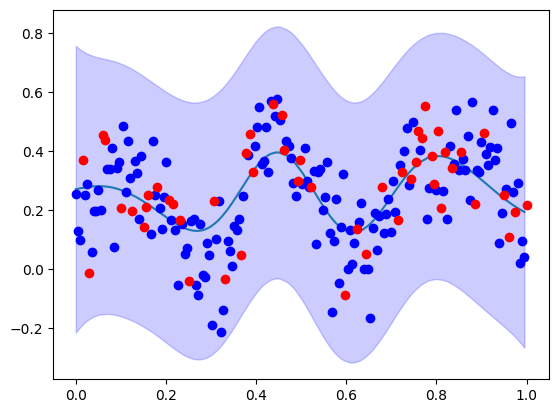

In [76]:
order = torch.argsort(eval_x)

plt.plot(eval_x[order].detach().numpy(), pred_means[order].detach().numpy())
plt.fill_between(eval_x[order].detach().numpy(), 
                 pred_means[order].detach().numpy() + 2 * pred_std[order].detach().numpy(),
                 pred_means[order].detach().numpy() - 2 * pred_std[order].detach().numpy(),
                 color="b", alpha=0.2)

plt.plot(eval_x.detach().numpy(), eval_y.detach().numpy(), "bo")
plt.plot(x.detach().numpy(), y.detach().numpy(), "ro")

In [77]:
# np.savez("plots/data/gp_rq/big_noise_cmll_fit.npz",
# # np.savez("plots/data/gp_rq/big_noise_mll_fit.npz",
#         x_train=x.detach().numpy(),
#         y_train=y.detach().numpy(),
#         x_test=eval_x[order].detach().numpy(),
#         y_test=eval_y[order].detach().numpy(),
#         f_test=eval_f[order].detach().numpy(),
#         pred_mu=pred_means[order].detach().numpy(),
#         pred_sigma=pred_std[order].detach().numpy()
#         )